### Dummy Train to Overfit

In [112]:
from utility.utils import *
from dataset.dataset import *
from dataset.transform import *
from model.loss import *
from model.unet import UNet256_3x3
from training.classifier import NucleiClassifier
from model.eval import create_validation_dirs
from dataset.submission import *

import torch
from torch.autograd import Variable as V
import torch.nn.functional as F
import torch.optim as optim

from skimage.morphology import label
from collections import OrderedDict
import matplotlib.pyplot as plt
import cv2
import shutil
import os

### Create Random Train and Validation Set

In [3]:
main_path = '../data/ds_bowl_2018/'
full_path = '../data/ds_bowl_2018/full_data/'

In [4]:
create_validation_dirs(main_path, full_path, 0.85)

Copied 569 training and 101 validation data


### Training

In [5]:
train_path = '../data/ds_bowl_2018/train/'
valid_path = '../data/ds_bowl_2018/valid/'

3b957237bc1e09740b58a414282393d3a91dde996b061e7061f4198fb03dab2e.png


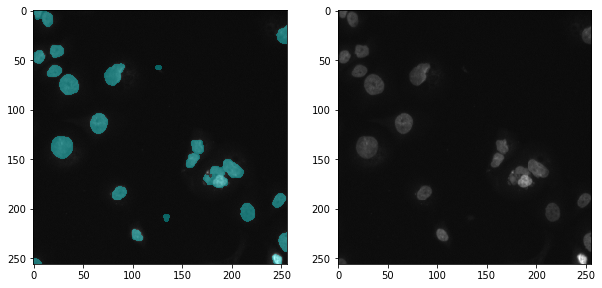

c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441.png


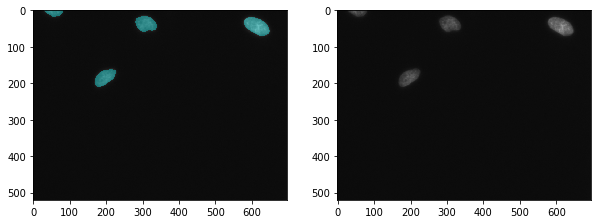

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0.png


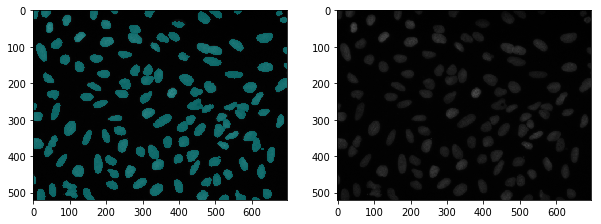

942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0.png


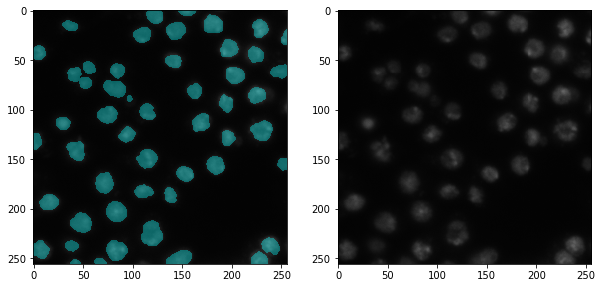

94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0.png


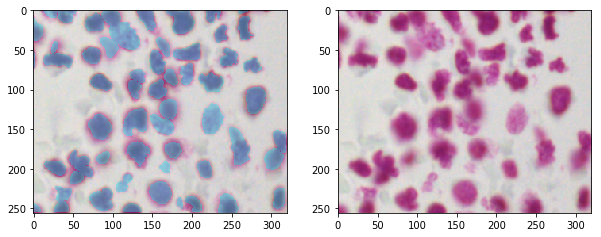

In [6]:
# Look at training images
image_mask_paths = get_image_onemask_paths(train_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d.png


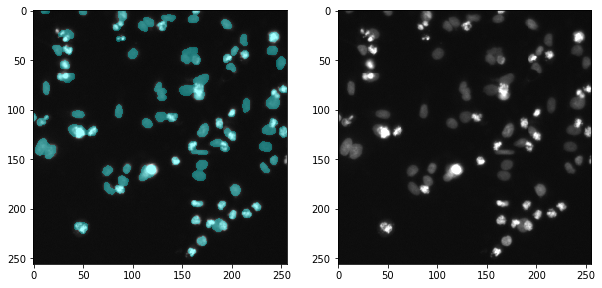

b1a239838c7dbb34ffea851ad537899f24da62f4e3f3fd6d835ff7b922f27313.png


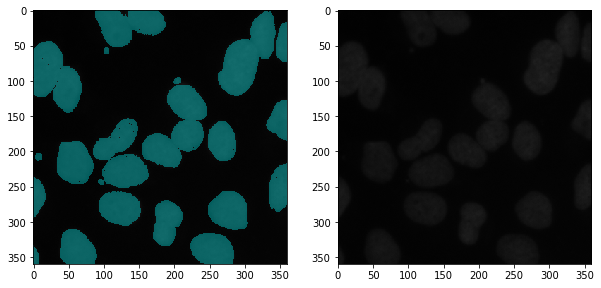

b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1.png


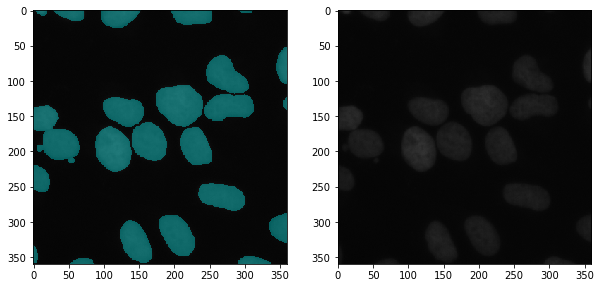

f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81.png


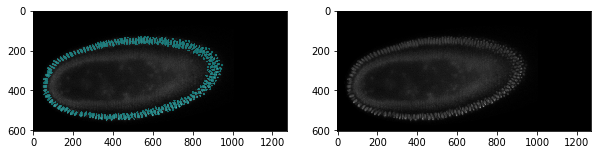

52a6b8ae4c8e0a8a07a31b8e3f401d8811bf1942969c198e51dfcbd98520aa60.png


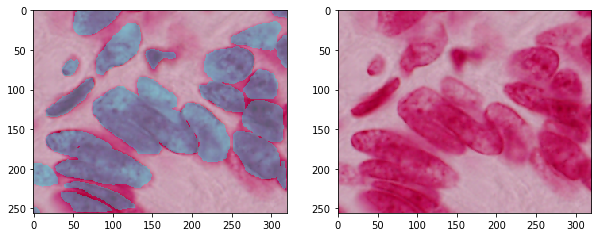

In [7]:
# Look at validation images
image_mask_paths = get_image_onemask_paths(valid_path)
for img_path , mask_path in image_mask_paths[:5]:
    show_image(img_path, mask_path, figsize=(10, 10))

### Training

In [8]:
def augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image, mask = fix_resize_transform2(image, mask, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    mask = mask[None, :] / 255 
    return image.astype(np.float64), mask.astype(np.float64), index

In [9]:
# create trainloader
trn_ds = NucleiDataset(train_path, transform=augment, mode='train')
trn_dl = DataLoader(trn_ds, batch_size=16, shuffle=True)
# create validloader
val_ds = NucleiDataset(valid_path, transform=augment, mode='valid')
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [10]:
# training definition
net = UNet256_3x3(in_shape=(3, 256, 256), num_classes=1).double()
#optimizer = optim.Adam(net.parameters(), lr=0.1)
optimizer = optim.RMSprop(net.parameters())
bce_loss2d = BCELoss2d()

In [13]:
# init classifier
classifier = NucleiClassifier(net, 100)

In [14]:
# train for 10 epochs
classifier.train(train_loader=trn_dl, valid_loader=val_dl, optimizer=optimizer, epochs=11, threshold=0.5)

Epoch: 1
Training : [0.7543 , 0.6107],Validation : [0.6358 , 0.6826]
Epoch: 2
Training : [0.455 , 0.7824],Validation : [0.4577 , 0.7545]
Epoch: 3
Training : [0.4172 , 0.8002],Validation : [0.4282 , 0.7959]
Epoch: 4
Training : [0.4464 , 0.782],Validation : [0.9188 , 0.6274]
Epoch: 5
Training : [0.3746 , 0.8195],Validation : [5.3279 , 0.2446]
Epoch: 6
Training : [0.4211 , 0.7976],Validation : [0.335 , 0.8393]
Epoch: 7
Training : [0.3443 , 0.8366],Validation : [0.3953 , 0.7914]
Epoch: 8
Training : [0.3 , 0.8601],Validation : [0.3307 , 0.8347]
Epoch: 9
Training : [0.3226 , 0.841],Validation : [0.767 , 0.631]
Epoch: 10
Training : [0.2867 , 0.8662],Validation : [0.4194 , 0.7964]
Epoch: 11
Training : [0.3214 , 0.8541],Validation : [0.3032 , 0.8567]


In [15]:
# save model
classifier.save_model('../data/ds_bowl_2018/models/unet256_model', '../data/ds_bowl_2018/models/unet256_optim')

### Visualize Evaluation

		 Image 					 Mask 				 Predicted Mask


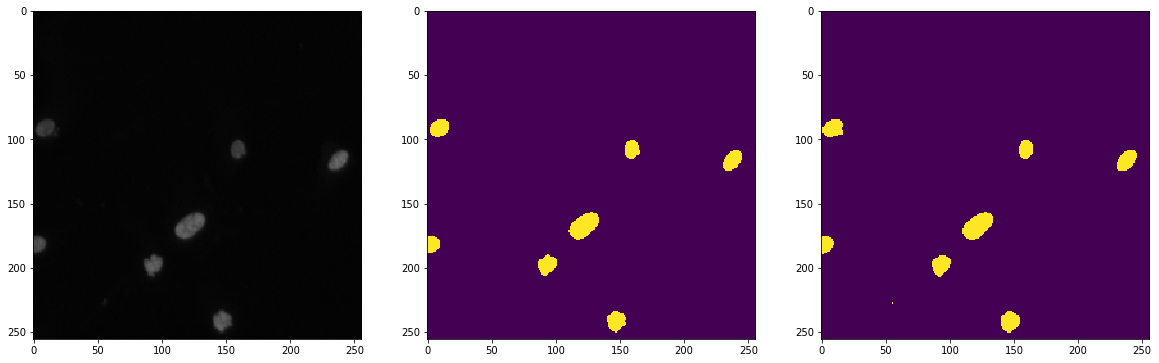

In [21]:
show_predictions(trn_dl, classifier,0.5, 1)

		 Image 					 Mask 				 Predicted Mask


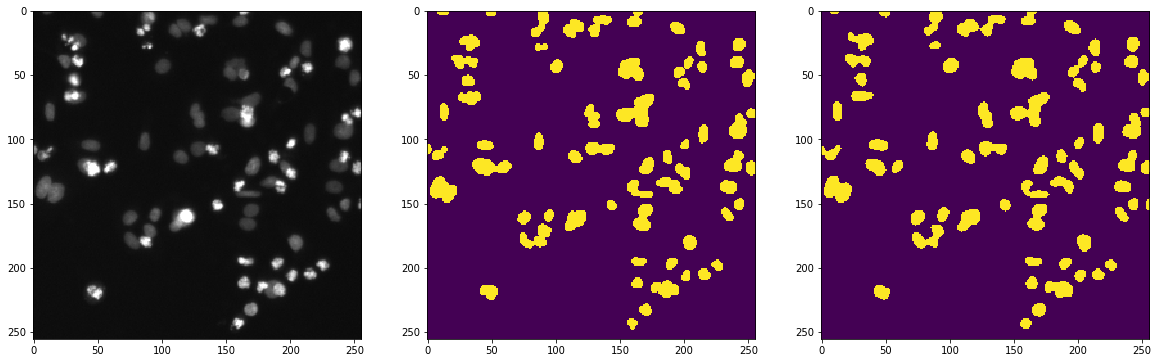

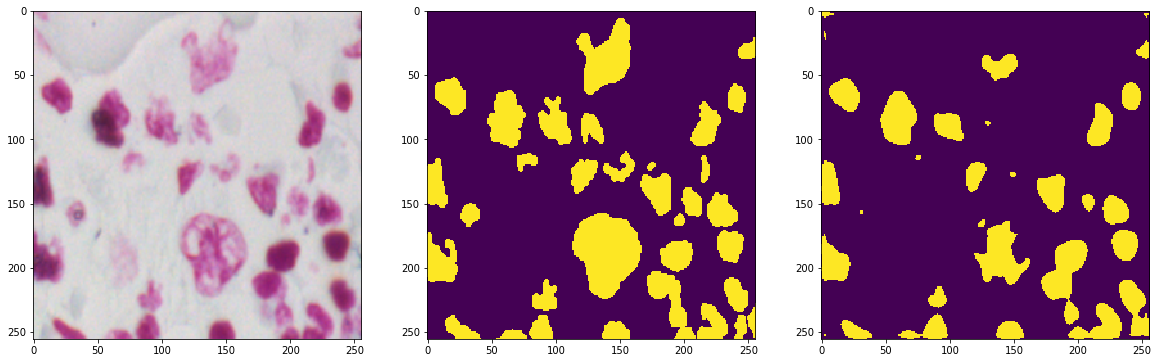

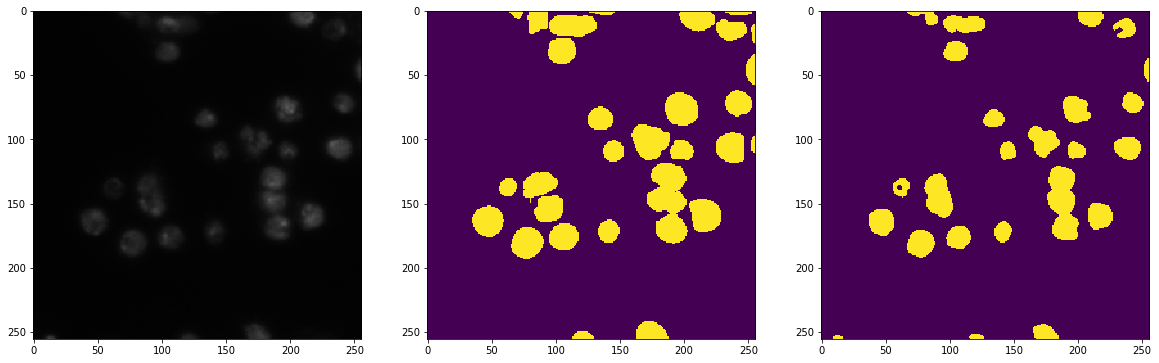

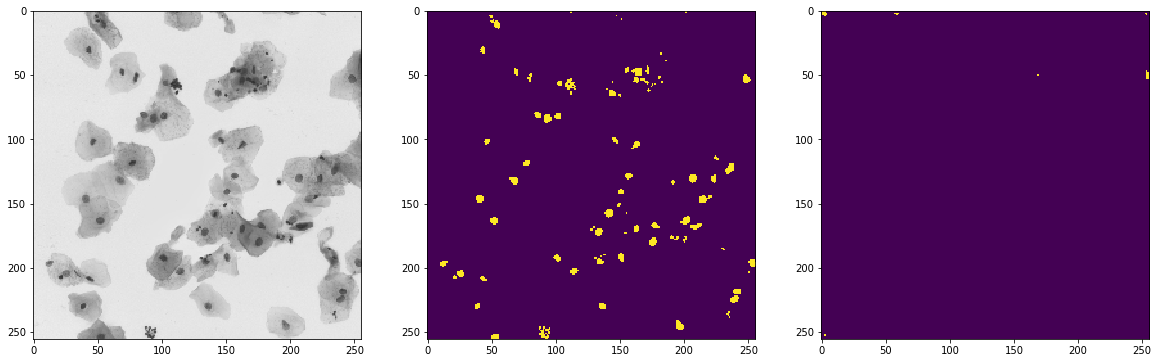

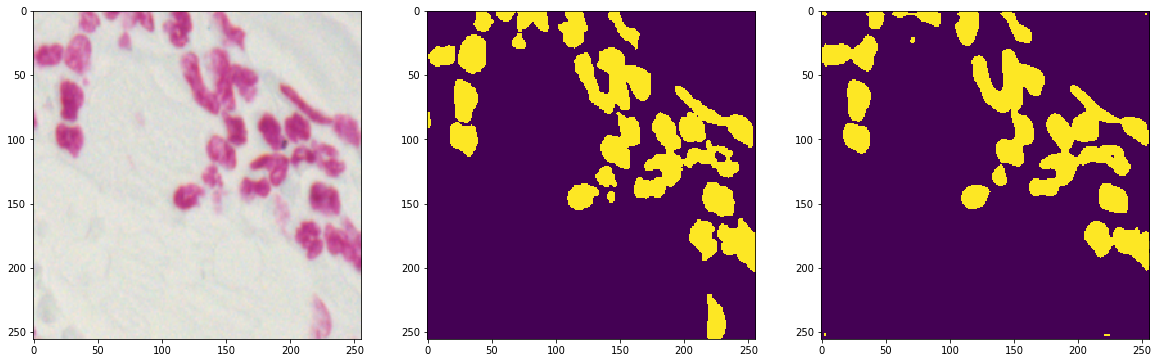

In [22]:
show_predictions(val_dl, classifier, 0.5, 5)

### Make Predictions

In [32]:
def test_augment(image, mask, index, sz = 256):
    # resize image for Unet256
    image = fix_resize_transform(image, sz, sz)
    # normalize pixel intensities
    image = (image.transpose((2,0,1))) / 255 
    return image.astype(np.float64), index

In [43]:
# create trainloader
test_ds = NucleiDataset('../data/ds_bowl_2018/test/', transform=test_augment, mode='test')
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [44]:
preds = classifier.predict(test_dl)

In [140]:
test_ds.__getitem__(1)[1]

'ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8'

In [144]:
img = plt.imread('../data/ds_bowl_2018/test/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8/images/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8.png')

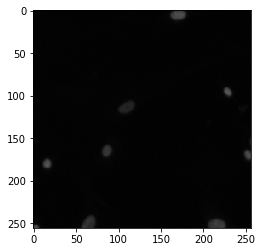

In [145]:
plt.imshow(img)

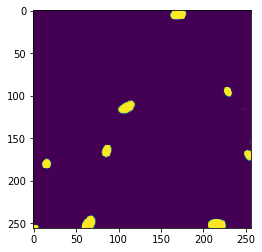

In [135]:
plt.imshow(preds[1][0, 0])

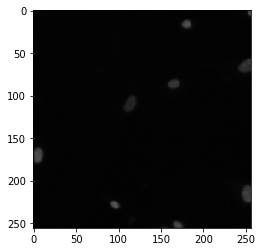

In [136]:
plt.imshow(test_ds.__getitem__(1)[0].T)

In [138]:
label((preds[1][0, 0] > 0.5))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0]])

In [137]:
np.unique(label((preds[1][0, 0] > 0.5)))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [150]:
train_labels = pd.read_csv('../data/ds_bowl_2018/csv/stage1_train_labels.csv')

In [207]:
id0 =  np.unique(train_labels.ImageId)[0]
len(train_labels[train_labels.ImageId == id0])

27

In [208]:
img = cv2.imread('../data/ds_bowl_2018/train/' + id0 + '/one_mask.png', cv2.IMREAD_GRAYSCALE)

In [222]:
np.unique(label(img, 8, connectivity=0))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

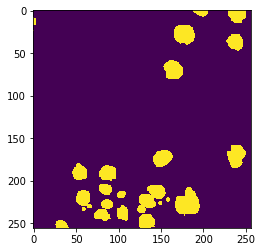

In [223]:
plt.imshow(img)

In [176]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [177]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ds.image_dirs):
    id_ = id_.split('/')[-2]
    rle = list(prob_to_rles(preds[n][0,0]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [178]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('../data/ds_bowl_2018/submissions/unet_basic.csv', index=False)

In [179]:
from IPython.display import FileLink

In [180]:
FileLink('../data/ds_bowl_2018/submissions/unet_basic.csv')

/home/ubuntu/deeplearning/data/ds_bowl_2018/submissions/unet_basic.csv